In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_series(time, series, format=("-"), start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-04 11:02:46--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.24.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.24.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K   214KB/s    in 0.3s    

2020-04-04 11:02:48 (214 KB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



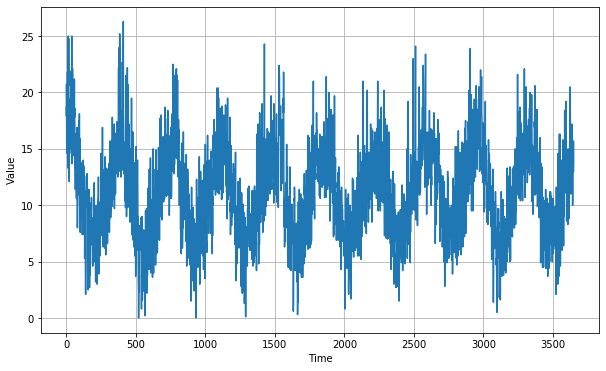

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 5s 477ms/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 2s 170ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 2s 172ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 2s 170ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 2s 170ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 2s 170ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 2s 169ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 2s 169ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 2s 171ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10/10 [==============================] - 2s 170ms/step - loss: 13.7512 - mae: 14.1192
Epoch 11/100
10/10 

[1e-08, 0.0001, 0, 60]

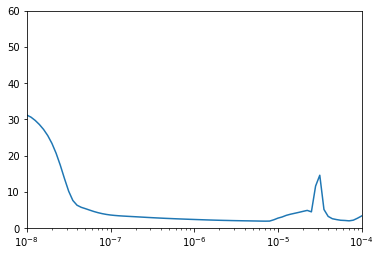

In [31]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100)

Epoch 1/100
10/10 [==============================] - 5s 450ms/step - loss: 18.5232 - mae: 19.6762
Epoch 2/100
10/10 [==============================] - 2s 170ms/step - loss: 4.8811 - mae: 5.2989
Epoch 3/100
10/10 [==============================] - 2s 168ms/step - loss: 3.1952 - mae: 3.6469
Epoch 4/100
10/10 [==============================] - 2s 171ms/step - loss: 2.7510 - mae: 3.2045
Epoch 5/100
10/10 [==============================] - 2s 169ms/step - loss: 2.6068 - mae: 3.0534
Epoch 6/100
10/10 [==============================] - 2s 168ms/step - loss: 2.3625 - mae: 2.8137
Epoch 7/100
10/10 [==============================] - 2s 170ms/step - loss: 2.2146 - mae: 2.6699
Epoch 8/100
10/10 [==============================] - 2s 168ms/step - loss: 2.1189 - mae: 2.5745
Epoch 9/100
10/10 [==============================] - 2s 170ms/step - loss: 2.0549 - mae: 2.5077
Epoch 10/100
10/10 [==============================] - 2s 171ms/step - loss: 1.9839 - mae: 2.4347
Epoch 11/100
10/10 [=================

10/10 [==============================] - 2s 170ms/step - loss: 1.5853 - mae: 2.0295
Epoch 86/100
10/10 [==============================] - 2s 169ms/step - loss: 1.5878 - mae: 2.0310
Epoch 87/100
10/10 [==============================] - 2s 170ms/step - loss: 1.5877 - mae: 2.0315
Epoch 88/100
10/10 [==============================] - 2s 169ms/step - loss: 1.5885 - mae: 2.0320
Epoch 89/100
10/10 [==============================] - 2s 172ms/step - loss: 1.5981 - mae: 2.0408
Epoch 90/100
10/10 [==============================] - 2s 169ms/step - loss: 1.5845 - mae: 2.0282
Epoch 91/100
10/10 [==============================] - 2s 170ms/step - loss: 1.5833 - mae: 2.0273
Epoch 92/100
10/10 [==============================] - 2s 170ms/step - loss: 1.5800 - mae: 2.0216
Epoch 93/100
10/10 [==============================] - 2s 170ms/step - loss: 1.5758 - mae: 2.0201
Epoch 94/100
10/10 [==============================] - 2s 170ms/step - loss: 1.5824 - mae: 2.0257
Epoch 95/100
10/10 [=======================

In [33]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

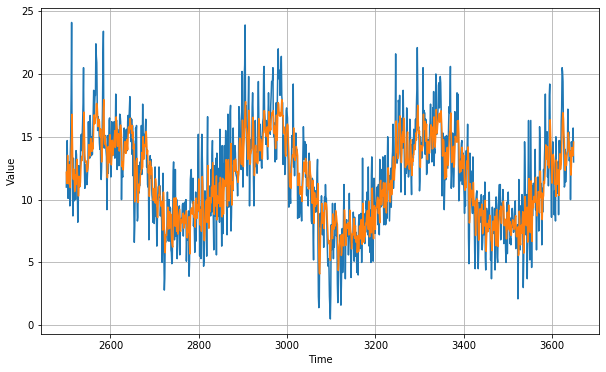

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [34]:
rnn_forecast

array([12.16999 , 11.284642, 11.933875, ..., 13.47602 , 13.575846,
       14.576644], dtype=float32)

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8395109